# <strong>데이터 입출력 (Chapter 7)
<strong>입출력 작업

In [1]:
# 기본 입출력 작업 : text, ndarray, SQL
# pandas 모듈을 활용 : 상동 및 CSV, JSON을 추가적 가능
# PyTable을 사용한 입출력 : HDF5 표준을 활용한 대규모 입출력 작업
!rm ./data/number.*

<br></br>
## <STRONG>1 기본 파이썬 입출력
Input-Output Operations
### <strong>01 SQL 데이터베이스
sqlite3

In [2]:
# DB와 연결을 설정
import sqlite3
import numpy as np
filename = './data/number'
con = sqlite3.Connection(filename + '.db')
query = 'Create Table numbs (Date date, No1 real, No2 real)'
con.execute(query)   # execute : 명령입력

# input 01 : 테이블에 데이터 추가하기 : 1 줄 추가
import datetime
con.execute('Insert Into numbs  values(?,?,?)', (datetime.datetime.now(), 0.12, 7.3))

# input 02 : 10,000개 데이터를 생성후 입력하기
data = np.random.standard_normal((10000, 2)).round(5)
print(data.shape)
for row in data:
    con.execute('INSERT INTO numbs VALUES(?, ?, ?)',
                (datetime.datetime.now(), row[0], row[1]))
con.commit()  # commit  : 입력시행 (범하다)

(10000, 2)


In [3]:
# load 01 : 저장한 데이터 불러오기
con.execute('SELECT * FROM numbs').fetchmany(4)

[('2018-01-02 10:23:41.363631', 0.12, 7.3),
 ('2018-01-02 10:23:41.365748', -0.22266, 0.86991),
 ('2018-01-02 10:23:41.365893', 0.63346, 1.19462),
 ('2018-01-02 10:23:41.365914', 1.13999, -1.22335)]

In [4]:
# load 02 : 한번에 특정 column 만 호출
pointer = con.execute('SELECT   Date, No2   FROM numbs')
for i in range(3):
    print(pointer.fetchone())
con.close()

('2018-01-02 10:23:41.363631', 7.3)
('2018-01-02 10:23:41.365748', 0.86991)
('2018-01-02 10:23:41.365893', 1.19462)


### <strong>02 Numpy 활용한 SQlite
numpy 의 dtype를 지정하면 Sqlite의 자료형 변환의 수고를 덜어준다

con.executemany() 데이터 전체입력함수

In [5]:
%%time 
import sqlite3
import numpy as np
query = """CREATE TABLE numbers (No1 real, No2 real, 
                                 No3 real, No4 real, No5 real)"""
con = sqlite3.connect('./data/number.db')
con.execute(query)

data = np.random.standard_normal((1000000, 5)).round(5)
con.executemany('INSERT INTO numbers VALUES (?, ?, ?, ?, ?)', data)
con.commit()

CPU times: user 6.44 s, sys: 81.8 ms, total: 6.52 s
Wall time: 6.68 s


In [6]:
!ls ./data/number.* -l

-rw-r--r-- 1 markbaum markbaum 53149696  1월  2 10:23 ./data/number.db


In [7]:
%%time
temp = con.execute('SELECT * FROM numbers').fetchall()
print(temp[:2])  # 전체 데이터 불러온 뒤 index 2까지 출력
temp = 0.0

[(-0.75977, -1.1668, -0.67039, -0.51925, 0.49838), (0.00907, -0.21774, -0.28857, -0.3507, 1.1898)]
CPU times: user 1.1 s, sys: 64.2 ms, total: 1.17 s
Wall time: 1.17 s


In [8]:
%%time
query = 'SELECT * FROM numbers WHERE No1 > 0 AND No2 < 0'
res = np.array(con.execute(query).fetchall()).round(3)

CPU times: user 405 ms, sys: 32.2 ms, total: 437 ms
Wall time: 440 ms


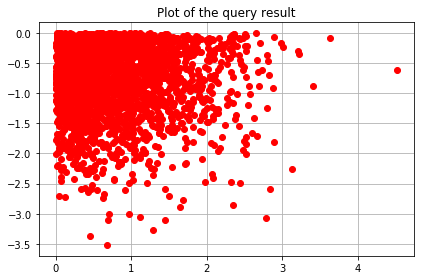

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
res = res[::100]    # every 100th result
plt.plot(res[:, 0], res[:, 1], 'ro')
plt.title('Plot of the query result')
plt.grid(True); plt.tight_layout(); plt.show()

### <strong>03 Pandas 활용한 SQlite
query 결과를 pandas로 변환

In [10]:
# 메모리에 업로드후 작업시 빠르게 작업이 가능
filename = './data/number'
con = sqlite3.Connection(filename + '.db')
import pandas as pd
%time data = pd.read_sql('SELECT * FROM  numbers', con)
con.close()                # 메모리 로딩 후 Sqlite3를 닫는다
data.head(3)

CPU times: user 1.39 s, sys: 107 ms, total: 1.49 s
Wall time: 1.5 s


,No1,No2,No3,No4,No5
0,-0.75977,-1.16680,-0.67039,-0.51925,0.49838
1,0.00907,-0.21774,-0.28857,-0.35070,1.18980
2,-0.25506,-0.21466,-0.95173,1.32384,-0.19275


In [11]:
# Query문을 활용한 데이터 추출
%time data[(data['No1'] > 0) & (data['No2'] < 0)].head(3)

CPU times: user 8.7 ms, sys: 8.08 ms, total: 16.8 ms
Wall time: 16.2 ms


,No1,No2,No3,No4,No5
1,0.00907,-0.21774,-0.28857,-0.35070,1.18980
5,0.70288,-1.34906,-1.12806,-0.83270,1.07310
8,0.48408,-0.86510,-0.34383,-0.91339,-1.41759


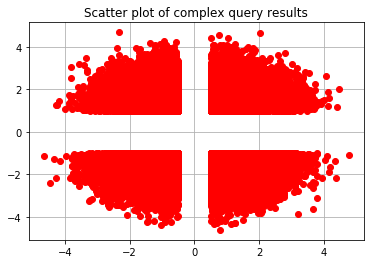

CPU times: user 782 ms, sys: 352 ms, total: 1.13 s
Wall time: 741 ms


In [12]:
%%time
res = data[['No1', 'No2']][ ((data['No1'] > 0.5) | 
                             (data['No1'] < -0.5))
                          & ((data['No2'] < -1) | 
                             (data['No2'] > 1))]
plt.plot(res.No1, res.No2, 'ro')
plt.grid(True);    plt.title('Scatter plot of complex query results')
plt.axis('tight'); plt.show()

### <strong>04 HDFS를 pandas 에서
pd.HDFStore()

In [13]:
# SQL과 같은 데이터를 HDFS로 저장 (속도가 SQL보다 더 빠르다)
h5s = pd.HDFStore(filename + '.h5s', 'w')  
%time h5s['data'] = data  # 데이터 입력
print(h5s)
h5s.close()               # 저장절차 종료

CPU times: user 22.1 ms, sys: 35.8 ms, total: 57.9 ms
Wall time: 57.9 ms
<class 'pandas.io.pytables.HDFStore'>
File path: ./data/number.h5s



In [14]:
%%time
# HDFS로 읽기
h5s = pd.HDFStore(filename + '.h5s', 'r')
temp = h5s['data']
h5s.close()               # 읽기절차 종료

CPU times: user 8.45 ms, sys: 20.1 ms, total: 28.5 ms
Wall time: 28.3 ms


In [15]:
# 저장자료와 읽은자료 동질성 확인
np.allclose(np.array(temp), np.array(data))

True

In [16]:
# h5s가 10% 더 작은 용량을 갖는다
!ls ./data/number.* -l

-rw-r--r-- 1 markbaum markbaum 53149696  1월  2 10:23 ./data/number.db
-rw-rw-r-- 1 markbaum markbaum 48007192  1월  2 10:23 ./data/number.h5s


### <strong>05 CSV로 저장
Data as CSV File

In [17]:
%time data.to_csv(filename + '.csv')

CPU times: user 5.06 s, sys: 47.1 ms, total: 5.11 s
Wall time: 5.11 s


In [18]:
# h5s가 10% 더 작은 용량을 갖는다
!ls ./data/number.* -l

-rw-rw-r-- 1 markbaum markbaum 48831576  1월  2 10:23 ./data/number.csv
-rw-r--r-- 1 markbaum markbaum 53149696  1월  2 10:23 ./data/number.db
-rw-rw-r-- 1 markbaum markbaum 48007192  1월  2 10:23 ./data/number.h5s


CPU times: user 855 ms, sys: 52.2 ms, total: 907 ms
Wall time: 906 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a4be58320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2a478f7e48>]], dtype=object)

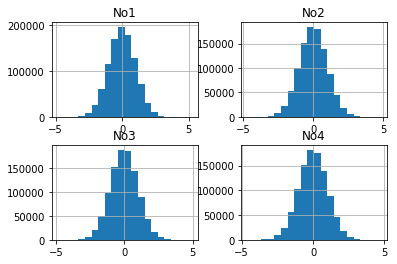

In [19]:
%%time
# bins = 20 : 구간을 20단계로 나눈다
pd.read_csv(filename + '.csv')[['No1', 'No2','No3', 'No4']].hist(bins = 20)

### <Strong>06 Excel 로 저장
Data as Excel File

In [20]:
%time data[:100000].to_excel(filename + '.xlsx')

CPU times: user 15.6 s, sys: 193 ms, total: 15.8 s
Wall time: 15.7 s


CPU times: user 4.89 s, sys: 19.3 ms, total: 4.91 s
Wall time: 4.92 s


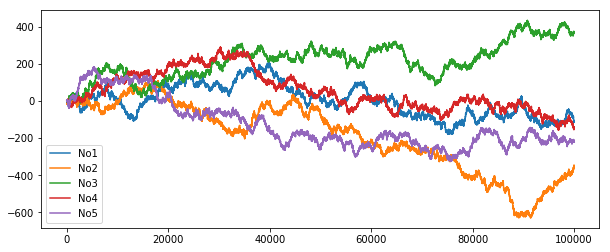

In [21]:
%time pd.read_excel(filename + '.xlsx', 'Sheet1').cumsum().plot(figsize=(10,4))
# title: Paths of random data from Excel file

In [22]:
!ls ./data/number.* -l

-rw-rw-r-- 1 markbaum markbaum 48831576  1월  2 10:23 ./data/number.csv
-rw-r--r-- 1 markbaum markbaum 53149696  1월  2 10:23 ./data/number.db
-rw-rw-r-- 1 markbaum markbaum 48007192  1월  2 10:23 ./data/number.h5s
-rw-rw-r-- 1 markbaum markbaum  4370030  1월  2 10:24 ./data/number.xlsx


In [23]:
# 결론
# Excel은 일부분만 저정함에도 시간이 상당소요
# HDFS 형식이 가장 용량이 작고 효율적이다
# Csv는 가장 용량이 큰데, 이는 메모리 과다점유로 인한 성능둔화 원인이 된다

<br>
## <strong>3 PyTable를 활용한 고속 입출력 
HDFS를 활용한 입출력 연산 성능 최적화 (Fast I/O with PyTables)

In [24]:
import numpy as np
import tables as tb
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

### <strong>01 Table 만들기
PyTable

In [25]:
# filename = path + 'tab.h5'
h5 = tb.open_file(filename, 'w')
rows = 2000000
row_des = { 'Date': tb.StringCol(26, pos=1), # 26글자 String
            'No1': tb.IntCol(pos=2),         # 정수열 1
            'No2': tb.IntCol(pos=3),         # 정수열 2
            'No3': tb.Float64Col(pos=4),     # 부동소숫점(소숫점 4자리)
            'No4': tb.Float64Col(pos=5)}     # 부동소숫점(소숫점 5자리)

In [26]:
# 압축하지 않은 테이터 저장방식을 활용
filters = tb.Filters(complevel = 0)
tab = h5.create_table('/', 'ints_floats', row_des,
                      title='Integers and Floats',
                      expectedrows=rows, filters=filters)
tab

/ints_floats (Table(0,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [27]:
%%time
pointer = tab.row
ran_int = np.random.randint(0, 10000, size=(rows, 2))
ran_flo = np.random.standard_normal((rows, 2)).round(5)

for i in range(rows): # for 반복문으로, 데이터를 입력한다
    pointer['Date'] = dt.datetime.now()
    pointer['No1'] = ran_int[i, 0]
    pointer['No2'] = ran_int[i, 1] 
    pointer['No3'] = ran_flo[i, 0]
    pointer['No4'] = ran_flo[i, 1] 
    pointer.append()
tab.flush()          # HDFS의 commit 명령

CPU times: user 7.29 s, sys: 71.2 ms, total: 7.36 s
Wall time: 7.36 s


In [28]:
# 입력한 객체의 내용 확인 : ndarray와 비슷하게 출력
tab

/ints_floats (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [29]:
# HDSF를 담을 Zeros 생성
dty = np.dtype([('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'),
                                 ('No3', '<f8'), ('No4', '<f8')])
sarray = np.zeros(len(ran_int), dtype=dty)
sarray

array([(b'', 0, 0,  0.,  0.), (b'', 0, 0,  0.,  0.), (b'', 0, 0,  0.,  0.),
       ..., (b'', 0, 0,  0.,  0.), (b'', 0, 0,  0.,  0.),
       (b'', 0, 0,  0.,  0.)],
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

In [30]:
%%time
# HDFS객체 옮겨 담기 : 순식간에 처리가 완료된다
sarray['Date'] = dt.datetime.now()
sarray['No1'] = ran_int[:, 0]
sarray['No2'] = ran_int[:, 1]
sarray['No3'] = ran_flo[:, 0]
sarray['No4'] = ran_flo[:, 1]

CPU times: user 54.9 ms, sys: 16.2 ms, total: 71.1 ms
Wall time: 69.9 ms
Compiler : 111 ms


In [31]:
# np.array --> table 생성하기
h5.create_table('/', 'ints_floats_from_array', sarray,
                      title = 'Integers and Floats',
                      expectedrows = rows, filters = filters)

/ints_floats_from_array (Table(2000000,)) 'Integers and Floats'
  description := {
  "Date": StringCol(itemsize=26, shape=(), dflt=b'', pos=0),
  "No1": Int32Col(shape=(), dflt=0, pos=1),
  "No2": Int32Col(shape=(), dflt=0, pos=2),
  "No3": Float64Col(shape=(), dflt=0.0, pos=3),
  "No4": Float64Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (2621,)

In [32]:
# 중복된 테이블은 삭제한다
h5.remove_node('/', 'ints_floats_from_array')

### <strong>02 Table 활용하기
PyTable

In [33]:
# 객체를 slice 로 접근하기
tab[:3]

array([(b'2018-01-02 10:24:21.697779', 6538,  668,  0.03704,  1.77393),
       (b'2018-01-02 10:24:21.697862',  213, 9159,  2.01996,  0.15577),
       (b'2018-01-02 10:24:21.697868',  662, 6851, -0.16152,  0.28232)],
      dtype=[('Date', 'S26'), ('No1', '<i4'), ('No2', '<i4'), ('No3', '<f8'), ('No4', '<f8')])

In [34]:
# 객체를 slice 로 접근하기
tab[:3]['No4']

array([ 1.77393,  0.15577,  0.28232])

In [35]:
# numpy의 유니버셜 함수를 바로 적용가능
# No3 컬럼의 총합
%time np.sum(tab[:]['No3'])

CPU times: user 32.1 ms, sys: 32.1 ms, total: 64.1 ms
Wall time: 63.5 ms


2630.4583699999998

In [36]:
# No1 컬럼의 편차 총합
%time np.sum(np.sqrt(tab[:]['No1']))

CPU times: user 19.2 ms, sys: 40.2 ms, total: 59.4 ms
Wall time: 58.6 ms


133340478.38899373

2000000
CPU times: user 127 ms, sys: 68 ms, total: 195 ms
Wall time: 195 ms


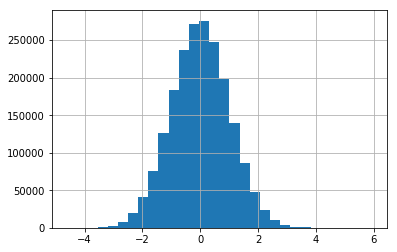

In [37]:
%%time
# table 객체를 plot으로 시각화
plt.hist(tab[:]['No3'], bins=30)
plt.grid(True)
print(len(tab[:]['No3']))

CPU times: user 324 ms, sys: 106 ms, total: 430 ms
Wall time: 304 ms


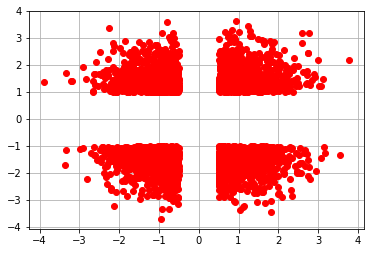

In [38]:
%%time
# table 객체를 Query 문으로 데이터 선별하기
res = np.array([(row['No3'], row['No4']) for row in
        tab.where('((No3 < -0.5) | (No3 > 0.5)) \
                 & ((No4 < -1) | (No4 > 1))')])[::100]
plt.plot(res.T[0], res.T[1], 'ro')
plt.grid(True)

In [39]:
%%time
# query문 연산
results = [(row['No1'], row['No2']) for row in
           tab.where('((No1 > 9800) | (No1 < 200)) \
                    & ((No2 > 4500) & (No2 < 5500))')]
[res  for res in results[:4]]

CPU times: user 90.2 ms, sys: 67.7 ms, total: 158 ms
Wall time: 69.2 ms


In [40]:
%%time
results = [(row['No1'], row['No2']) for row in
           tab.where('(No1 == 1234) & (No2 > 9776)')]
[res  for res in results]

CPU times: user 52.2 ms, sys: 3.69 ms, total: 55.9 ms
Wall time: 48 ms


### <strong>03 압축된 Table 다루기
Working with Compressed Tables

In [41]:
# 4단계 압축을 실시해도 속도 차이는 거의 없다
h5c = tb.open_file(filename + '.h5c', 'w')
filters = tb.Filters(complevel=4, complib = 'blosc')
tabc = h5c.create_table('/', 'ints_floats', sarray,
                        title = 'Integers and Floats',
                        expectedrows = rows, filters = filters)

In [42]:
%%time
res = np.array([(row['No3'], row['No4']) for row in
             tabc.where('((No3 < -0.5) | (No3 > 0.5)) \
                       & ((No4 < -1) | (No4 > 1))')])[::100]
# 살짝 느린 결과값을 출력

CPU times: user 260 ms, sys: 36 ms, total: 296 ms
Wall time: 255 ms


In [43]:
%time arr_non = tab.read()

CPU times: user 11.3 ms, sys: 36 ms, total: 47.3 ms
Wall time: 46.3 ms


In [44]:
# 저장 및 읽기 시간은 좀 걸리지만, 50% 용량이 절약된다
%time arr_com = tabc.read()
h5c.close()
!ls ./data/number.* -l

CPU times: user 12.7 ms, sys: 36.1 ms, total: 48.9 ms
Wall time: 48.1 ms
-rw-rw-r-- 1 markbaum markbaum  48831576  1월  2 10:23 ./data/number.csv
-rw-r--r-- 1 markbaum markbaum  53149696  1월  2 10:23 ./data/number.db
-rw-rw-r-- 1 markbaum markbaum 100030820  1월  2 10:24 ./data/number.h5c
-rw-rw-r-- 1 markbaum markbaum  48007192  1월  2 10:23 ./data/number.h5s
-rw-rw-r-- 1 markbaum markbaum   4370030  1월  2 10:24 ./data/number.xlsx


### <strong>04 배열 Table 다루기
Working with Arrays

In [45]:
%%time
arr_int = h5.create_array('/', 'integers', ran_int)
arr_flo = h5.create_array('/', 'floats', ran_flo)

CPU times: user 702 µs, sys: 48.2 ms, total: 48.9 ms
Wall time: 48.7 ms


In [46]:
h5.close()
# HDF5 기반의 자료형
# 관계형 DB에서 대용품으로 활용에 적합하다
# pandas와 결합하면 최적의 성능 및 용량을 발휘가능하다
# !rm ./data/number.db